In [2]:
!pip freeze | grep "qiskit"

qiskit==1.3.1
qiskit-aer==0.16.0
qiskit-algorithms==0.3.1
qiskit-experiments==0.8.1
qiskit-ibm-experiment==0.4.8
qiskit-ibm-provider==0.11.0
qiskit-ibm-runtime==0.34.0
qiskit-machine-learning==0.8.2
qiskit-nature==0.7.2


In [ ]:
from qiskit_ibm_runtime.fake_provider.backends import FakeKolkataV2
from qiskit.circuit.random import random_circuit
from qiskit.visualization import plot_error_map
from qiskit.compiler import transpile

In [4]:
backend = FakeKolkataV2()

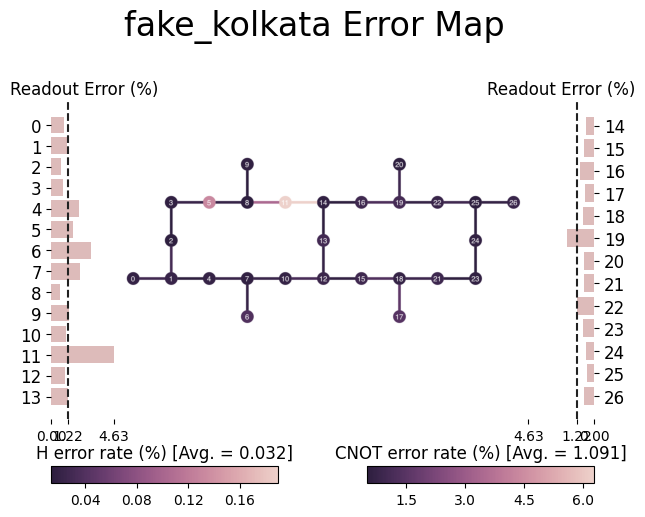

In [5]:
plot_error_map(backend, figsize=(7, 6))

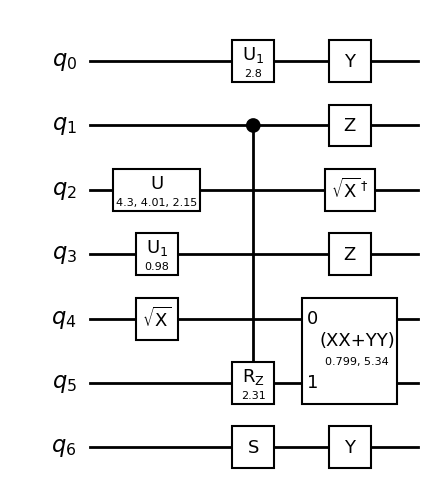

In [6]:
circ = random_circuit(7, depth=2, max_operands=2)
circ.draw(output="mpl", fold=-1, style="bw", idle_wires=False)

33


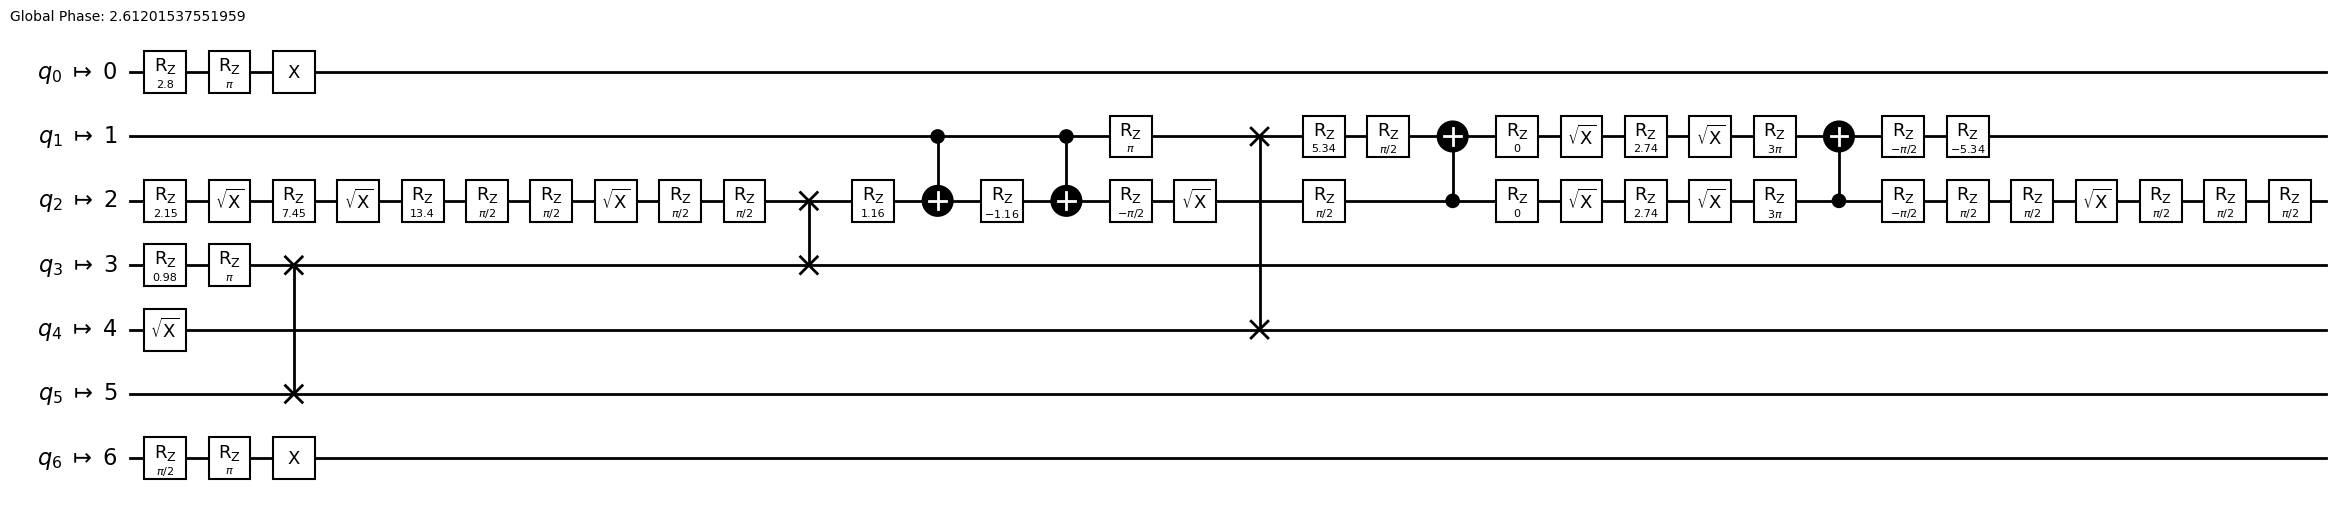

In [7]:
trans_circ = transpile(
    circ,
    backend,
    optimization_level=0,
    basis_gates=["x", "sx", "cx", "rz", "id", "swap"],
)

print(trans_circ.depth())
trans_circ.draw(output="mpl", fold=-1, style="bw", idle_wires=False)

16


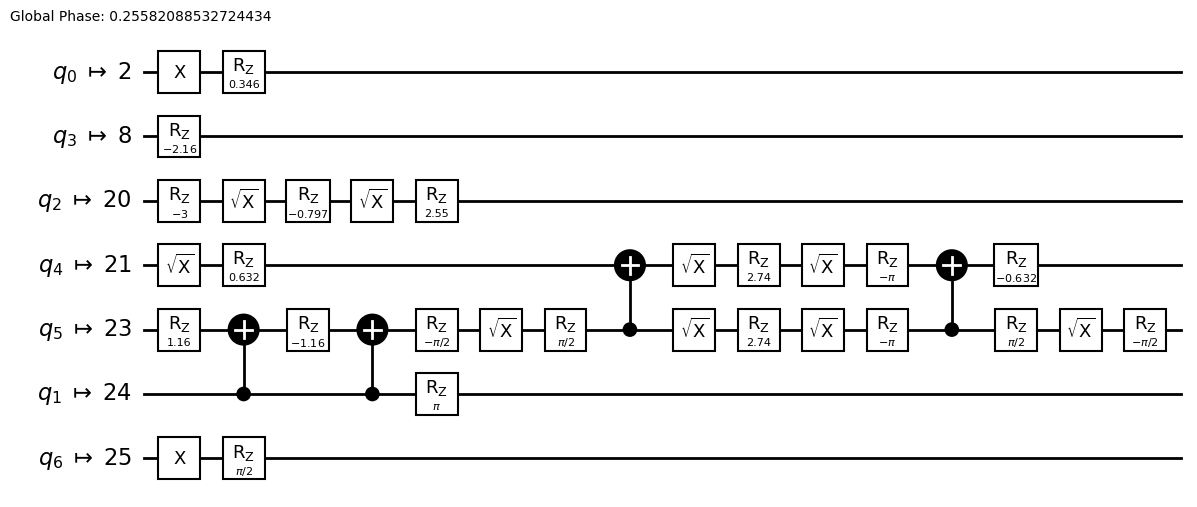

In [8]:
trans_circ = transpile(
    circ, backend, optimization_level=1, basis_gates=["x", "sx", "cx", "rz", "id"]
)

print(trans_circ.depth())
trans_circ.draw(output="mpl", fold=-1, style="bw", idle_wires=False)

30


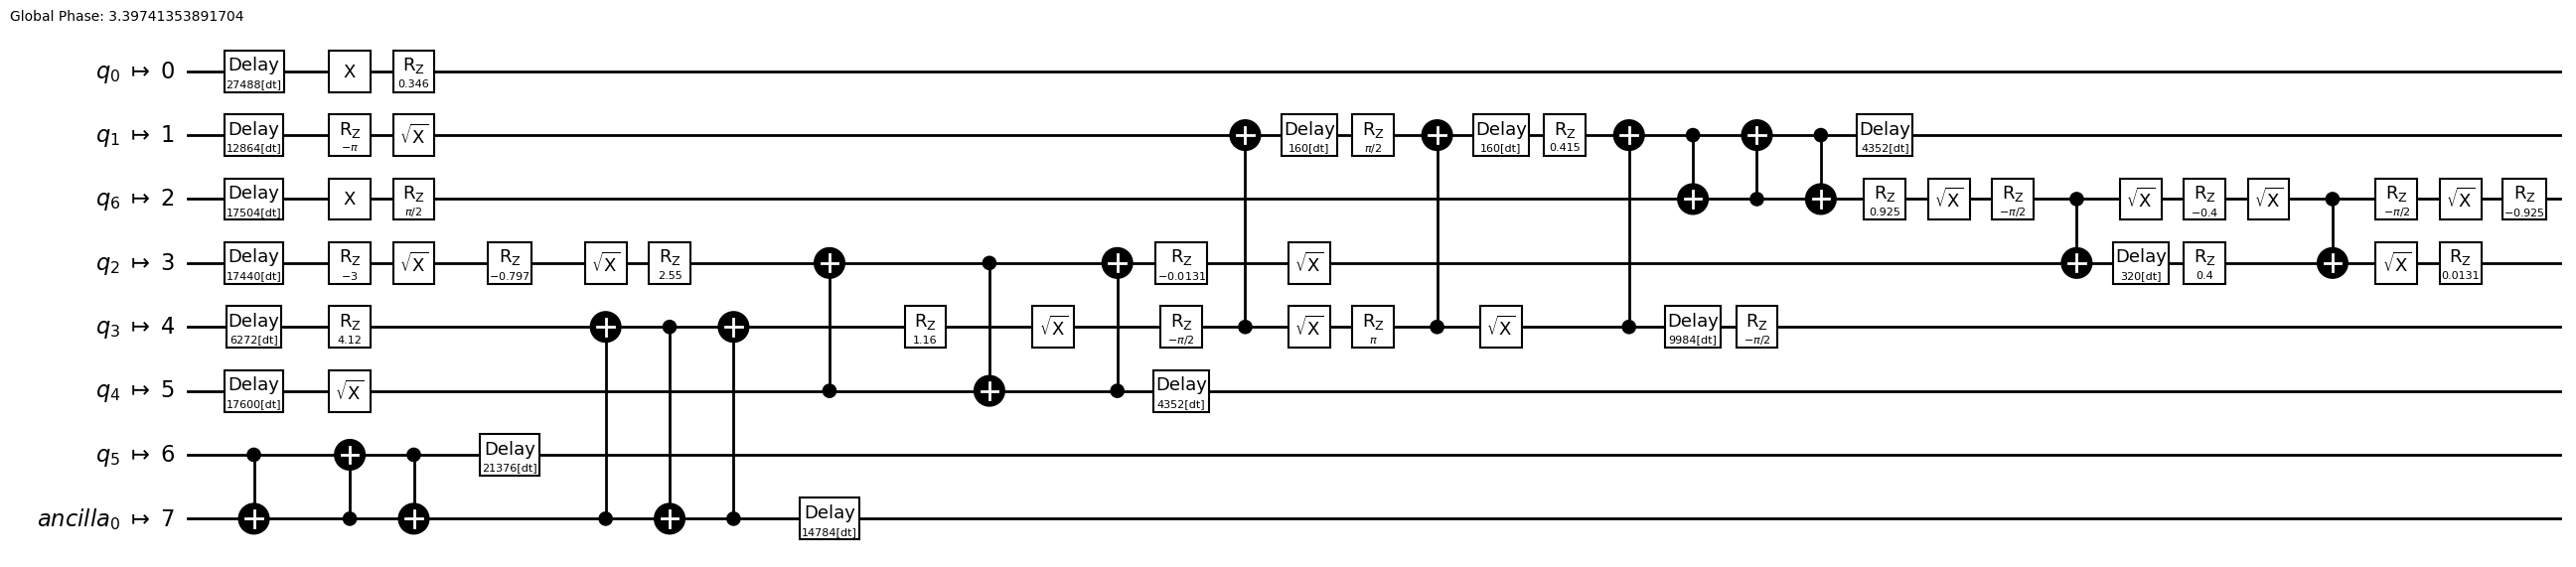

In [9]:
trans_circ = transpile(
    circ,
    backend,
    optimization_level=2,
    basis_gates=["x", "sx", "cx", "rz", "id"],
    initial_layout=[0, 1, 3, 4, 5, 6, 2],
    scheduling_method="alap",
)

print(trans_circ.depth())
trans_circ.draw(output="mpl", fold=-1, style="bw", idle_wires=False)

### An example of a transpiler pass

In [10]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.visualization import timeline_drawer

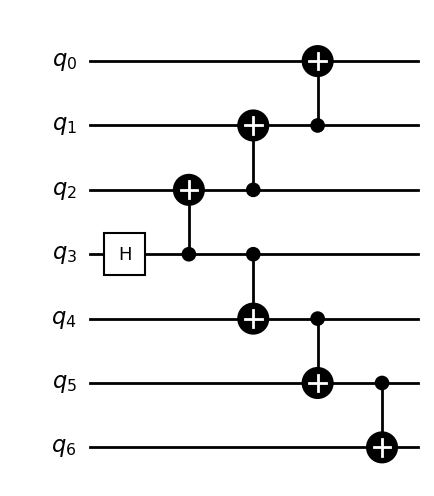

In [11]:
num_qubits = 7
qc = QuantumCircuit(num_qubits)
mid = num_qubits // 2

qc.h(mid)
for i in range(mid, 0, -1):
    qc.cx(i, i - 1)
for i in range(mid, num_qubits - 1):
    qc.cx(i, i + 1)

qc.draw("mpl", style="bw", fold=-1)

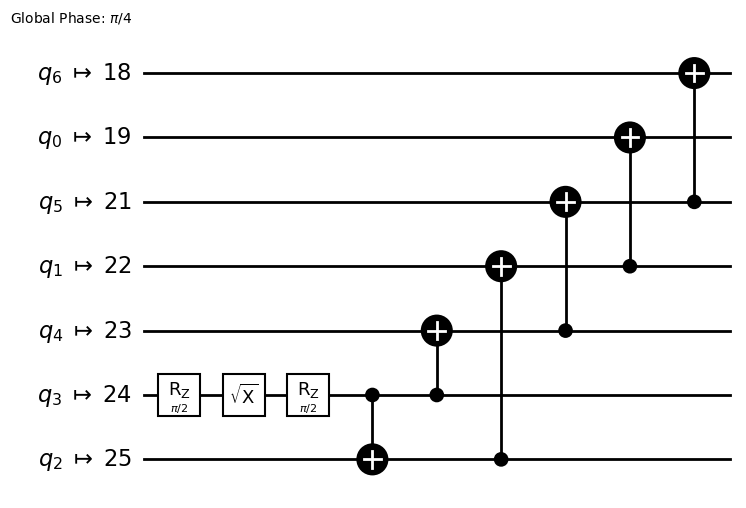

In [12]:
qc = transpile(qc, backend)

qc.draw("mpl", style="bw", fold=-1, idle_wires=False)

In [13]:
durations = InstructionDurations.from_backend(backend)
durations.duration_by_name_qubits

{('x', (0,)): (3.5555555555555554e-08, 's'),
 ('x', (1,)): (3.5555555555555554e-08, 's'),
 ('x', (2,)): (3.5555555555555554e-08, 's'),
 ('x', (3,)): (3.5555555555555554e-08, 's'),
 ('x', (4,)): (3.5555555555555554e-08, 's'),
 ('x', (5,)): (3.5555555555555554e-08, 's'),
 ('x', (6,)): (3.5555555555555554e-08, 's'),
 ('x', (7,)): (3.5555555555555554e-08, 's'),
 ('x', (8,)): (3.5555555555555554e-08, 's'),
 ('x', (9,)): (3.5555555555555554e-08, 's'),
 ('x', (10,)): (3.5555555555555554e-08, 's'),
 ('x', (11,)): (3.5555555555555554e-08, 's'),
 ('x', (12,)): (3.5555555555555554e-08, 's'),
 ('x', (13,)): (3.5555555555555554e-08, 's'),
 ('x', (14,)): (3.5555555555555554e-08, 's'),
 ('x', (15,)): (3.5555555555555554e-08, 's'),
 ('x', (16,)): (3.5555555555555554e-08, 's'),
 ('x', (17,)): (3.5555555555555554e-08, 's'),
 ('x', (18,)): (3.5555555555555554e-08, 's'),
 ('x', (19,)): (3.5555555555555554e-08, 's'),
 ('x', (20,)): (3.5555555555555554e-08, 's'),
 ('x', (21,)): (3.5555555555555554e-08, 's')

In [59]:
durations.get("cx", [0, 1])

1344

In [ ]:
# DURING REAL HARDWARE THIS IS NOT NEEDED
# you can pass ALAPScheduleAnalysis() as is
class ALAPCompat(ALAPScheduleAnalysis):
    @staticmethod
    def _get_node_duration(node, dag) -> int:
        op = node.op.to_mutable()

        qargs = (node.qargs[0]._index,)

        if len(node.qargs) > 1:
            qargs = qargs + (node.qargs[1]._index,)

        duration = durations.get(op.name, qargs)
        op.duration = duration
        dag.substitute_node(node, op, propagate_condition=False)

        return duration

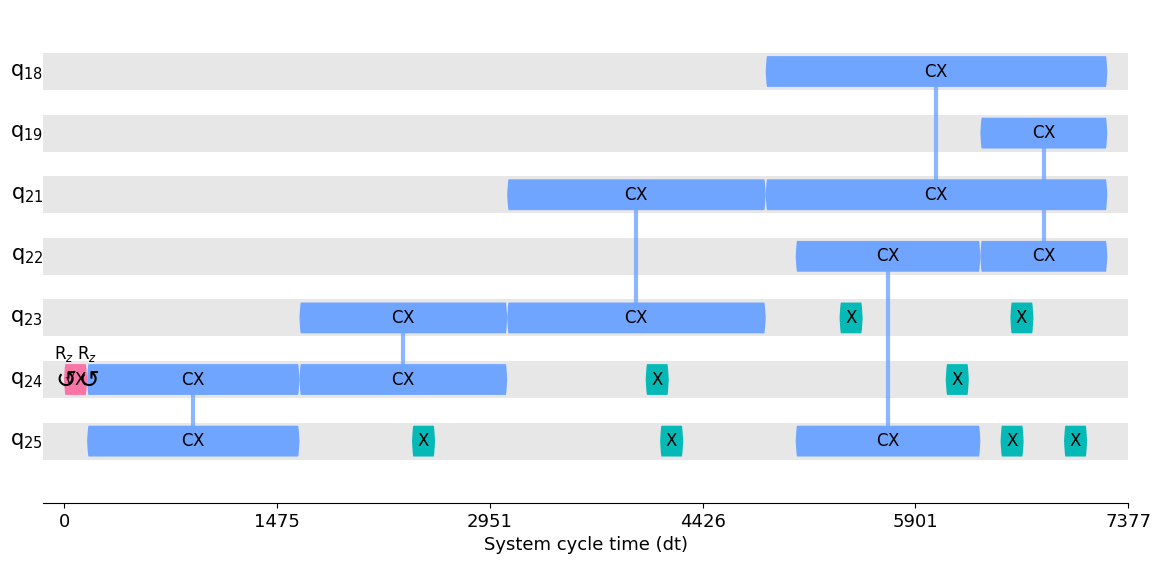

In [88]:
pm = PassManager([ALAPCompat(), PadDynamicalDecoupling(durations, [XGate()] * 2)])
qc_dd = pm.run(qc)
timeline_drawer(qc_dd, plot_barriers=True, idle_wires=False)